# Quantum Krylov method with multiqpus

## Quantum Krylov method


Quantum Krylov method is one of subspace methods. Subspace methods project a large matrix into a subspace, which has the solution. 
In the context of quantum classical hybrid algorithm, this projection is performed by quantum computer, and the (generalized) eigenvalue problem after the projection is solved by classical computer.

<img src="./subspace.png" alt="Subspace method" style="width: 800px;"/>

Suppose that the ground state is approximately contained in this subspace.
\begin{equation}
\vert g \rangle \approx \sum_{j=0}^{d-1} c_j \vert \psi_j \rangle.
\end{equation}

Multiplying by $H$ and taking the inner product with $\psi_i$, we obtain the equation
\begin{equation}
\langle \psi_i \vert H  \vert g \rangle 
=  \langle \psi_i \vert H \sum_{j=0}^{d-1} c_j \vert \psi_j \rangle 
=  \sum_{j=0}^{d-1} \langle \psi_i \vert H  \vert \psi_j \rangle c_j 
= \langle \psi_i \vert E_g \sum_{j=0}^{d-1} c_j \vert \psi_j \rangle
= E_g \sum_{j=0}^{d-1} \langle \psi_i  \vert \psi_j \rangle c_j .
\end{equation}
where $E_g$ is a ground state energy ($H \vert g \rangle = E_g \vert g \rangle$).
Note that $\lbrace \psi_i \rbrace$ is non-orthogonal states.
From this discussion, we obtain the following general eigenvalue equations:
\begin{equation}
\tilde{H} \vec{c} = E_g \tilde{S} \vec{c}.
\end{equation}

The Krylov subspace is a certaion subspace defined as a linear span of
\begin{equation}
\left\{ \vert \psi_0 \rangle, H \vert \psi_0 \rangle, H^2 \vert \psi_0 \rangle, ..., H^{d-1} \vert \psi_0 \rangle \right\}.
\end{equation}
Implementing power of $H$ on a quantum computer is possible using block encoding, but the cost (circuit depth) is expensive.

Instead of the original krylov subspace, we approximate it to unitary krylov subspace defined as
\begin{equation}
\operatorname{span} \left\{ \vert \psi_0 \rangle, U \vert \psi_0 \rangle, U^2 \vert \psi_0 \rangle, ..., U^{d-1} \vert \psi_0 \rangle \right\}.
\end{equation}

Hence, we need to calculate
\begin{equation}
\tilde{H}_{ij} = \langle \psi_i \vert H \vert \psi_j \rangle = \langle \psi_0 \vert {U^\dagger}^i  H U^j \vert \psi_0 \rangle, \ 
\tilde{S}_{ij} = \langle \psi_i \vert \psi_j \rangle = \langle \psi_0 \vert {U^\dagger}^i U^j \psi_0 \rangle
\end{equation}
on quantum computer and solve the generalized eigenvalue problem
\begin{equation}
\tilde{H} x = \lambda \tilde{S} x.
\end{equation}

## Setup CUDA-Q

In [1]:
import numpy as np

import cudaq

In [2]:
cudaq.set_target("nvidia-mqpu")

In [3]:
# Check the number of QPUs
num_qpus = cudaq.get_target().num_qpus()
num_qpus

5

## Quantum Chemistry Problem

In this notebook, we consider the hydrogen chain $\mathrm{H}_n$ as the target molecule. The hamiltonian can be obtained as follows:

In [4]:
# Number of hydrogen atoms.
hydrogen_count = 4

# Distance between the atoms in Angstroms.
bond_distance = 0.7474

# Define a linear chain of Hydrogen atoms
geometry = [("H", (0, 0, i * bond_distance)) for i in range(hydrogen_count)]

molecule, data = cudaq.chemistry.create_molecular_hamiltonian(geometry, "sto-3g", 1, 0)

num_electrons = data.n_electrons
num_qubits = 2 * data.n_orbitals

## Classical solution with NumPy

In [5]:
# Get the matrix
matrix = molecule.to_matrix()
# Solve it with NumPy
exact_gs = np.linalg.eigvalsh(matrix)[0]
print("Ground state energy:", exact_gs)

Ground state energy: -2.14355458044603


## Quantum Krylov with Statevector simulator

Prepare Hartree-Fock (HF) state as initial state $\vert \psi_0 \rangle$ and use (rough) Trotter circuits as unitary time evolution.

In [6]:
kernel, theta = cudaq.make_kernel(float)
qubits = kernel.qalloc(num_qubits)

# Hartree fock state
for i in range(qubits.size() // 2):
    kernel.x(qubits[i])

# First order trotter
for term in molecule:
    kernel.exp_pauli(theta * term.get_coefficient().real, qubits, term)

In [7]:
# This kernel method will be supported from 0.8.0 (cudaq.pauli_word is not supported)

# from cudaq.qis import x, exp_pauli

# @cudaq.kernel
# def hf_state(qubits: cudaq.qview):
#     for i in range(qubits.size() / 2):
#         x(qubits[i])

# pauli_strs, coeffs = zip(*[(term.to_string(False), term.get_coefficient().real) for term in molecule])
# coeffs = list(coeffs)

# @cudaq.kernel
# def trotter(qubits: cudaq.qview, paulis:list[cudaq.pauli_word], coeffs: list[float]):
#     for pauli, coeff in zip(paulis, coeff):
#         exp_pauli(coeff, qubits, pauli_str)

# @cudaq.kernel
# def circuit(coeffs: list[float]):
#     qubits = cudaq.qvector(num_qubits)
#     hf_state(qubits)
#     trotter(qubits, coeffs)

In [1]:
from cudaq import SpinOperator, State


def reverse_endian(spin: SpinOperator):
    return sum(
        term.get_coefficient() * SpinOperator.from_word(term.to_string(False)[::-1])
        for term in spin
    )


def inner_product(state1: State, state2: State, observable: SpinOperator | None = None):
    """
    Returns <state1 | state2> if observable is None else <state1|observable|state2>
    """
    if observable is None:
        return np.inner(
            np.array(state1, copy=False).conj(), np.array(state2, copy=False)
        )
    else:
        return (
            np.array(state1, copy=False).conj()
            @ reverse_endian(observable).to_matrix()  # Why need reverse here? Bug???
            @ np.array(state2, copy=False).T
        )


def get_gs_energy(h, s, threshold=1e-8):
    s_vals, s_vecs = eigh(s)
    good_vecs = np.array([vec for val, vec in zip(s_vals, s_vecs.T) if val > threshold])
    h_reg = good_vecs.conj() @ h @ good_vecs.T
    s_reg = good_vecs.conj() @ s @ good_vecs.T
    return eigh(h_reg, s_reg, eigvals_only=True)[0]

SyntaxError: invalid syntax (1572417483.py, line 22)

In [9]:
# Hyperparameter
krylov_dim = 10
dt = 0.2  # time step

In [10]:
from scipy.linalg import eigh

states_future = []
for i in range(krylov_dim):
    states_future.append(
        cudaq.get_state_async(kernel, float(dt * i), qpu_id=i % num_qpus)
    )

states = [future.get() for future in states_future]

h = np.empty((krylov_dim, krylov_dim), dtype=np.complex128)
s = np.empty((krylov_dim, krylov_dim), dtype=np.complex128)
for i in range(krylov_dim):
    for j in range(i + 1):
        state1 = states[i]
        state2 = states[j]

        s[i, j] = inner_product(state1, state2)
        s[j, i] = s[i, j].conjugate()

        h[i, j] = inner_product(state1, state2, molecule)
        h[j, i] = h[i, j].conjugate()

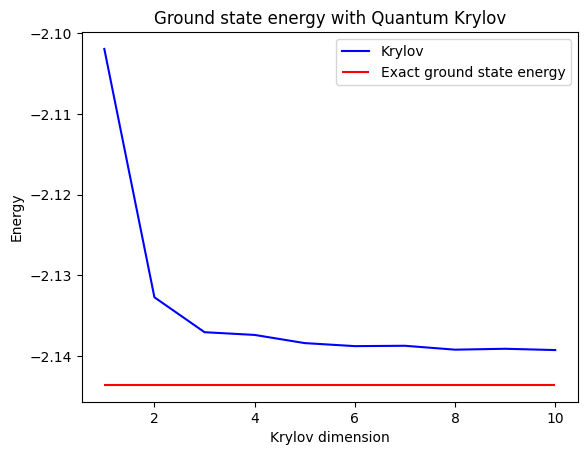

In [11]:
import matplotlib.pyplot as plt

expvals = []
for d in range(1, krylov_dim + 1):
    ev = get_gs_energy(h[:d, :d], s[:d, :d])
    expvals.append(ev)

plt.plot(range(1, krylov_dim + 1), expvals, color="blue", label="Krylov")
plt.hlines(
    exact_gs, xmin=1, xmax=krylov_dim, color="red", label="Exact ground state energy"
)
plt.legend()
plt.xlabel("Krylov dimension")
plt.ylabel("Energy")
plt.title("Ground state energy with Quantum Krylov")
plt.show()

### Discussion

- This error comes from the trotter error and the ground state is not in the subspace. The result will be improved using higher order trotter.
- Negative eigenvalues are present due to (trotter) error and regularized to remove them.
- Methods such as Hadamard test are needed to calculate innerproduct on real quantum devices.